# A work through of running k-function on example PD-L1 IHC data

In [1]:
import pandas as pd
import numpy as np
import umap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

/gpfs/mskmind_ess/pollardw/projects/luna/.venv/luna/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/mskmind_ess/pollardw/projects/luna/.venv/luna/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/gpfs/mskmind_ess/pollardw/projects/lu

In [2]:
!echo "Dask scheduler:" $LUNA_DASK_SCHEDULER

Dask scheduler: tcp://10.254.130.14:8786


## First, run stardist cell detection + cell measurements
* a cell expansion size of 8 um
* 40 cores for speedup
* we are using a BRIGHTFIELD_H_DAB image

In [3]:
USER = "pollardw"
SLIDE_DIR = "/gpfs/mskmind_emc/data_large/pathology/LUNG_18-193/slides/"
SLIDE_ID = "3756135"
SLIDE = f"{SLIDE_DIR}/{SLIDE_ID}.svs"
WORKDIR = f"/gpfs/mskmind_ess/{USER}/tmp/slides/{SLIDE_ID}/"

In [4]:
!python3 -m luna.pathology.cli.run_stardist_cell_detection \
    simple {SLIDE} \
    --num-cores 40 --cell-expansion-size 8 --image-type BRIGHTFIELD_H_DAB \
    --output-urlpath {WORKDIR}/stardist_v3 

2023-08-04 10:21:50.216 | INFO     | __main__:stardist_simple:49 - outputs already exist: /gpfs/mskmind_ess/pollardw/tmp/slides/3756135//stardist_v3
2023-08-04 10:21:50.217 | DEBUG    | luna.common.utils:wrapper:146 - stardist_simple ran in 0.01s


In [5]:
!ls -l {WORKDIR}/stardist_v3

total 2578849
-rw-r--r-- 1 pollardw pollardw   48651725 Aug  3 15:59 3756135_cell_objects.parquet
-rw-r--r-- 1 pollardw pollardw 2413387118 Aug  3 15:59 cell_detections.geojson
-rw-r--r-- 1 pollardw pollardw  178671770 Aug  3 15:58 cell_detections.tsv
-rw-r--r-- 1 pollardw pollardw        607 Aug  3 15:59 metadata.yml


In [6]:
pd.read_parquet(f"{WORKDIR}/stardist_v3/3756135_cell_objects.parquet")

Image  \
cell_id                                                          
cell-0       93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-1       93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-2       93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-3       93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-4       93ae51da2658d79511e400a129634c33fcffda47002c51...   
...                                                        ...   
cell-354705  93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-354706  93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-354707  93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-354708  93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-354709  93ae51da2658d79511e400a129634c33fcffda47002c51...   

                       Name  Class                Parent      ROI  x_coord  \
cell_id                                                                      
cell-0       PathCellObject    NaN  PathAnnotationObject  Polygon   6349.3   
cell-1       PathCellObject    NaN  PathAnnotationObject  Polygon   6420.0   
cell-2       PathCellObject    NaN  PathAnnotationObject  Polygon   6404.1   
cell-3       PathCellObject    NaN  PathAnnotationObject  Polygon   6391.7   
cell-4       PathCellObject    NaN  PathAnnotationObject  Polygon   6399.6   
...                     ...    ...                   ...      ...      ...   
cell-354705  PathCellObject    NaN  PathAnnotationObject  Polygon   9067.3   
cell-354706  PathCellObject    NaN  PathAnnotationObject  Polygon   9078.8   
cell-354707  PathCellObject    NaN  PathAnnotationObject  Polygon   9053.8   
cell-354708  PathCellObject    NaN  PathAnnotationObject  Polygon   9068.3   
cell-354709  PathCellObject    NaN  PathAnnotationObject  Polygon   9097.2   

             y_coord  Detection probability  Nucleus: Area µm^2  \
cell_id                                                           
cell-0        2024.7                 0.4655             12.8010   
cell-1        2058.3                 0.3672             11.6556   
cell-2        2060.0                 0.8402             56.9555   
cell-3        2058.0                 0.8270             41.8517   
cell-4        2067.5                 0.7311             34.4110   
...              ...                    ...                 ...   
cell-354705  13912.9                 0.8004             12.5252   
cell-354706  13915.9                 0.7662             15.9203   
cell-354707  13919.8                 0.6786             17.4626   
cell-354708  13928.6                 0.7792             13.3197   
cell-354709  14145.4                 0.5701             14.4228   

             Nucleus: Length µm  ...  DAB: Membrane: Mean  \
cell_id                          ...                        
cell-0                  13.3915  ...               0.0174   
cell-1                  13.2016  ...               0.0623   
cell-2                  27.8769  ...               0.0715   
cell-3                  24.2926  ...               0.0529   
cell-4                  23.4084  ...               0.1031   
...                         ...  ...                  ...   
cell-354705             13.1894  ...               0.4748   
cell-354706             15.1202  ...               0.2720   
cell-354707             15.6631  ...               0.1849   
cell-354708             13.5736  ...               0.1416   
cell-354709             14.1590  ...               0.0158   

             DAB: Membrane: Median  DAB: Membrane: Min  DAB: Membrane: Max  \
cell_id                                                                      
cell-0                      0.0175              0.0094              0.0242   
cell-1                      0.0568              0.0126              0.1559   
cell-2                      0.0707             -0.0064              0.1890   
cell-3                      0.0209             -0.0053              0.1726   
cell-4                      0.1039              0

## Next, run kfunction on the cell detections, here we use:
* a sliding window of size 1000, stride of 300
* a radius of 160 um
* The DAB Cytoplasm Mean intensity

In [7]:
!python3 -m luna.pathology.cli.extract_kfunction_statistics \
    {WORKDIR}/stardist_v3/{SLIDE_ID}_cell_objects.parquet  \
    --tile-size 1000 --tile-stride 300 --radius 160 --intensity-label 'DAB: Cytoplasm: Mean' \
    --output-urlpath {WORKDIR}/kfunct_v3 

2023-08-04 10:21:57.195 | INFO     | __main__:extract_kfunction:112 - Submitting tasks...
100%|███████████████████████████████████████| 1806/1806 [00:37<00:00, 48.47it/s]
2023-08-04 10:22:34.457 | INFO     | __main__:extract_kfunction:134 - Waiting for all tasks to complete...
2023-08-04 10:22:34.635 | INFO     | __main__:extract_kfunction:157 - Generated k-function feature data:
2023-08-04 10:22:34.635 | INFO     | __main__:extract_kfunction:158 -                x_coord  ...  ikfunction_r160_stainDAB_Cytoplasm_Mean_norm
address                 ...                                              
x1601_y2844       1601  ...                                      0.016854
x1601_y3144       1601  ...                                      0.724786
x1601_y3444       1601  ...                                      0.948209
x1601_y3744       1601  ...                                      0.974858
x1601_y4044       1601  ...                                      1.000000
...                ...  ...  

In [8]:
!ls -l {WORKDIR}/kfunct_v3

total 1
-rw-r--r-- 1 pollardw pollardw 43450 Aug  4 10:22 3756135_cell_objects_kfunction_supertiles.parquet
-rw-r--r-- 1 pollardw pollardw   558 Aug  4 10:22 metadata.yml


In [9]:
pd.read_parquet(f"{WORKDIR}/kfunct_v3/3756135_cell_objects_kfunction_supertiles.parquet")

x_coord  y_coord  xy_extent  tile_size tile_units  \
address                                                            
x1601_y2844       1601     2844       1000       1000         um   
x1601_y3144       1601     3144       1000       1000         um   
x1601_y3444       1601     3444       1000       1000         um   
x1601_y3744       1601     3744       1000       1000         um   
x1601_y4044       1601     4044       1000       1000         um   
...                ...      ...        ...        ...        ...   
x14201_y8544     14201     8544       1000       1000         um   
x14201_y12744    14201    12744       1000       1000         um   
x14201_y13044    14201    13044       1000       1000         um   
x14201_y13344    14201    13344       1000       1000         um   
x14201_y13644    14201    13644       1000       1000         um   

               ikfunction_r160_stainDAB_Cytoplasm_Mean  \
address                                                  
x1601_y2844                                   8.224484   
x1601_y3144                                 353.678969   
x1601_y3444                                 462.704272   
x1601_y3744                                 475.708456   
x1601_y4044                                 487.977051   
...                                                ...   
x14201_y8544                                  0.034433   
x14201_y12744                                 0.054800   
x14201_y13044                                 0.058960   
x14201_y13344                                 0.058960   
x14201_y13644                                 0.049733   

               ikfunction_r160_stainDAB_Cytoplasm_Mean_norm  
address                                                      
x1601_y2844                                        0.016854  
x1601_y3144                                        0.724786  
x1601_y3444                                        0.948209  
x1601_y3744                                        0.974858  
x1601_y4044                                        1.000000  
...                                                     ...  
x14201_y8544                                       0.000071  
x14201_y12744                                      0.000112  
x14201_y13044                                      0.000121  
x14201_y13344                                      0.000121  
x14201_y13644                                      0.000102  

[1534 rows x 7 columns]

In [10]:
!python3 -m luna.pathology.cli.extract_tile_statistics \
    {WORKDIR}/kfunct_v3/3756135_cell_objects_kfunction_supertiles.parquet \
    --output-urlpath {WORKDIR}/tile_stats_v3 

Index(['ikfunction_r160_stainDAB_Cytoplasm_Mean', 'ikfunction_r160_stainDAB_Cytoplasm_Mean_norm'], dtype='object')
2023-08-04 10:22:37.746 | INFO     | __main__:cli:49 -    ikfunction_r160_stainDAB_Cytoplasm_Mean_nobs  ...  ikfunction_r160_stainDAB_Cytoplasm_Mean_norm_pct100
0                                          1534  ...                                                1.0  

[1 rows x 20 columns]
2023-08-04 10:22:37.771 | DEBUG    | luna.common.utils:wrapper:146 - cli ran in 0.06s


In [11]:
!ls -l {WORKDIR}/tile_stats_v3

total 1
-rw-r--r-- 1 pollardw pollardw 21383 Aug  4 10:22 3756135_cell_objects_kfunction_supertiles_tile_stats.parquet
-rw-r--r-- 1 pollardw pollardw   499 Aug  4 10:22 metadata.yml


In [12]:
pd.read_parquet(f"{WORKDIR}/tile_stats_v3/3756135_cell_objects_kfunction_supertiles_tile_stats.parquet").T

0
ikfunction_r160_stainDAB_Cytoplasm_Mean_nobs         1534.000000
ikfunction_r160_stainDAB_Cytoplasm_Mean_mean          123.710165
ikfunction_r160_stainDAB_Cytoplasm_Mean_variance    15769.844084
ikfunction_r160_stainDAB_Cytoplasm_Mean_skewness        0.547807
ikfunction_r160_stainDAB_Cytoplasm_Mean_kurtosis       -1.123069
ikfunction_r160_stainDAB_Cytoplasm_Mean_pct0            0.016900
ikfunction_r160_stainDAB_Cytoplasm_Mean_pct25           0.093758
ikfunction_r160_stainDAB_Cytoplasm_Mean_pct50          69.960561
ikfunction_r160_stainDAB_Cytoplasm_Mean_pct75         247.211946
ikfunction_r160_stainDAB_Cytoplasm_Mean_pct100        487.977051
ikfunction_r160_stainDAB_Cytoplasm_Mean_norm_nobs    1534.000000
ikfunction_r160_stainDAB_Cytoplasm_Mean_norm_mean       0.253516
ikfunction_r160_stainDAB_Cytoplasm_Mean_norm_va...      0.066226
ikfunction_r160_stainDAB_Cytoplasm_Mean_norm_sk...      0.547807
ikfunction_r160_stainDAB_Cytoplasm_Mean_norm_ku...     -1.123069
ikfunction_r160_stainDAB_Cytoplasm_Mean_norm_pct0       0.000035
ikfunction_r160_stainDAB_Cytoplasm_Mean_norm_pct25      0.000192
ikfunction_r160_stainDAB_Cytoplasm_Mean_norm_pct50      0.143369
ikfunction_r160_stainDAB_Cytoplasm_Mean_norm_pct75      0.506606
ikfunction_r160_stainDAB_Cytoplasm_Mean_norm_pc...      1.000000

In [13]:
!ls -l {WORKDIR}/kfunct_v3

total 49
-rw-r--r-- 1 pollardw pollardw 43450 Aug  4 10:22 3756135_cell_objects_kfunction_supertiles.parquet
-rw-r--r-- 1 pollardw pollardw   558 Aug  4 10:22 metadata.yml


In [14]:
pd.read_parquet(f"{WORKDIR}/kfunct_v3/3756135_cell_objects_kfunction_supertiles.parquet")

x_coord  y_coord  xy_extent  tile_size tile_units  \
address                                                            
x1601_y2844       1601     2844       1000       1000         um   
x1601_y3144       1601     3144       1000       1000         um   
x1601_y3444       1601     3444       1000       1000         um   
x1601_y3744       1601     3744       1000       1000         um   
x1601_y4044       1601     4044       1000       1000         um   
...                ...      ...        ...        ...        ...   
x14201_y8544     14201     8544       1000       1000         um   
x14201_y12744    14201    12744       1000       1000         um   
x14201_y13044    14201    13044       1000       1000         um   
x14201_y13344    14201    13344       1000       1000         um   
x14201_y13644    14201    13644       1000       1000         um   

               ikfunction_r160_stainDAB_Cytoplasm_Mean  \
address                                                  
x1601_y2844                                   8.224484   
x1601_y3144                                 353.678969   
x1601_y3444                                 462.704272   
x1601_y3744                                 475.708456   
x1601_y4044                                 487.977051   
...                                                ...   
x14201_y8544                                  0.034433   
x14201_y12744                                 0.054800   
x14201_y13044                                 0.058960   
x14201_y13344                                 0.058960   
x14201_y13644                                 0.049733   

               ikfunction_r160_stainDAB_Cytoplasm_Mean_norm  
address                                                      
x1601_y2844                                        0.016854  
x1601_y3144                                        0.724786  
x1601_y3444                                        0.948209  
x1601_y3744                                        0.974858  
x1601_y4044                                        1.000000  
...                                                     ...  
x14201_y8544                                       0.000071  
x14201_y12744                                      0.000112  
x14201_y13044                                      0.000121  
x14201_y13344                                      0.000121  
x14201_y13644                                      0.000102  

[1534 rows x 7 columns]

In [15]:
!python3 -m luna.pathology.cli.visualize_tile_labels_png \
    {SLIDE_DIR}/{SLIDE_ID}.svs \
    {WORKDIR}/kfunct_v3/3756135_cell_objects_kfunction_supertiles.parquet \
    --plot-labels ikfunction_r160_stainDAB_Cytoplasm_Mean_norm \
    --requested-magnification 1 \
    --output-urlpath {WORKDIR}/kfunct_viz_v3

2023-08-04 10:22:44.175 | DEBUG    | luna.common.utils:wrapper:146 - get_downscaled_thumbnail ran in 0.17s
100%|█████████████████████████████████████| 1534/1534 [00:01<00:00, 1517.04it/s]
2023-08-04 10:22:45.494 | INFO     | __main__:cli:80 - Saved ikfunction_r160_stainDAB_Cytoplasm_Mean_norm visualization at /gpfs/mskmind_ess/pollardw/tmp/slides/3756135/kfunct_viz_v3/tile_scores_and_labels_visualization_ikfunction_r160_stainDAB_Cytoplasm_Mean_norm.png
2023-08-04 10:22:45.497 | DEBUG    | luna.common.utils:wrapper:146 - cli ran in 1.61s


In [16]:
!ls -l {WORKDIR}/kfunct_viz_v3

total 1
-rw-r--r-- 1 pollardw pollardw     581 Aug  4 10:22 metadata.yml
-rw-r--r-- 1 pollardw pollardw 1934724 Aug  4 10:22 tile_scores_and_labels_visualization_ikfunction_r160_stainDAB_Cytoplasm_Mean_norm.png


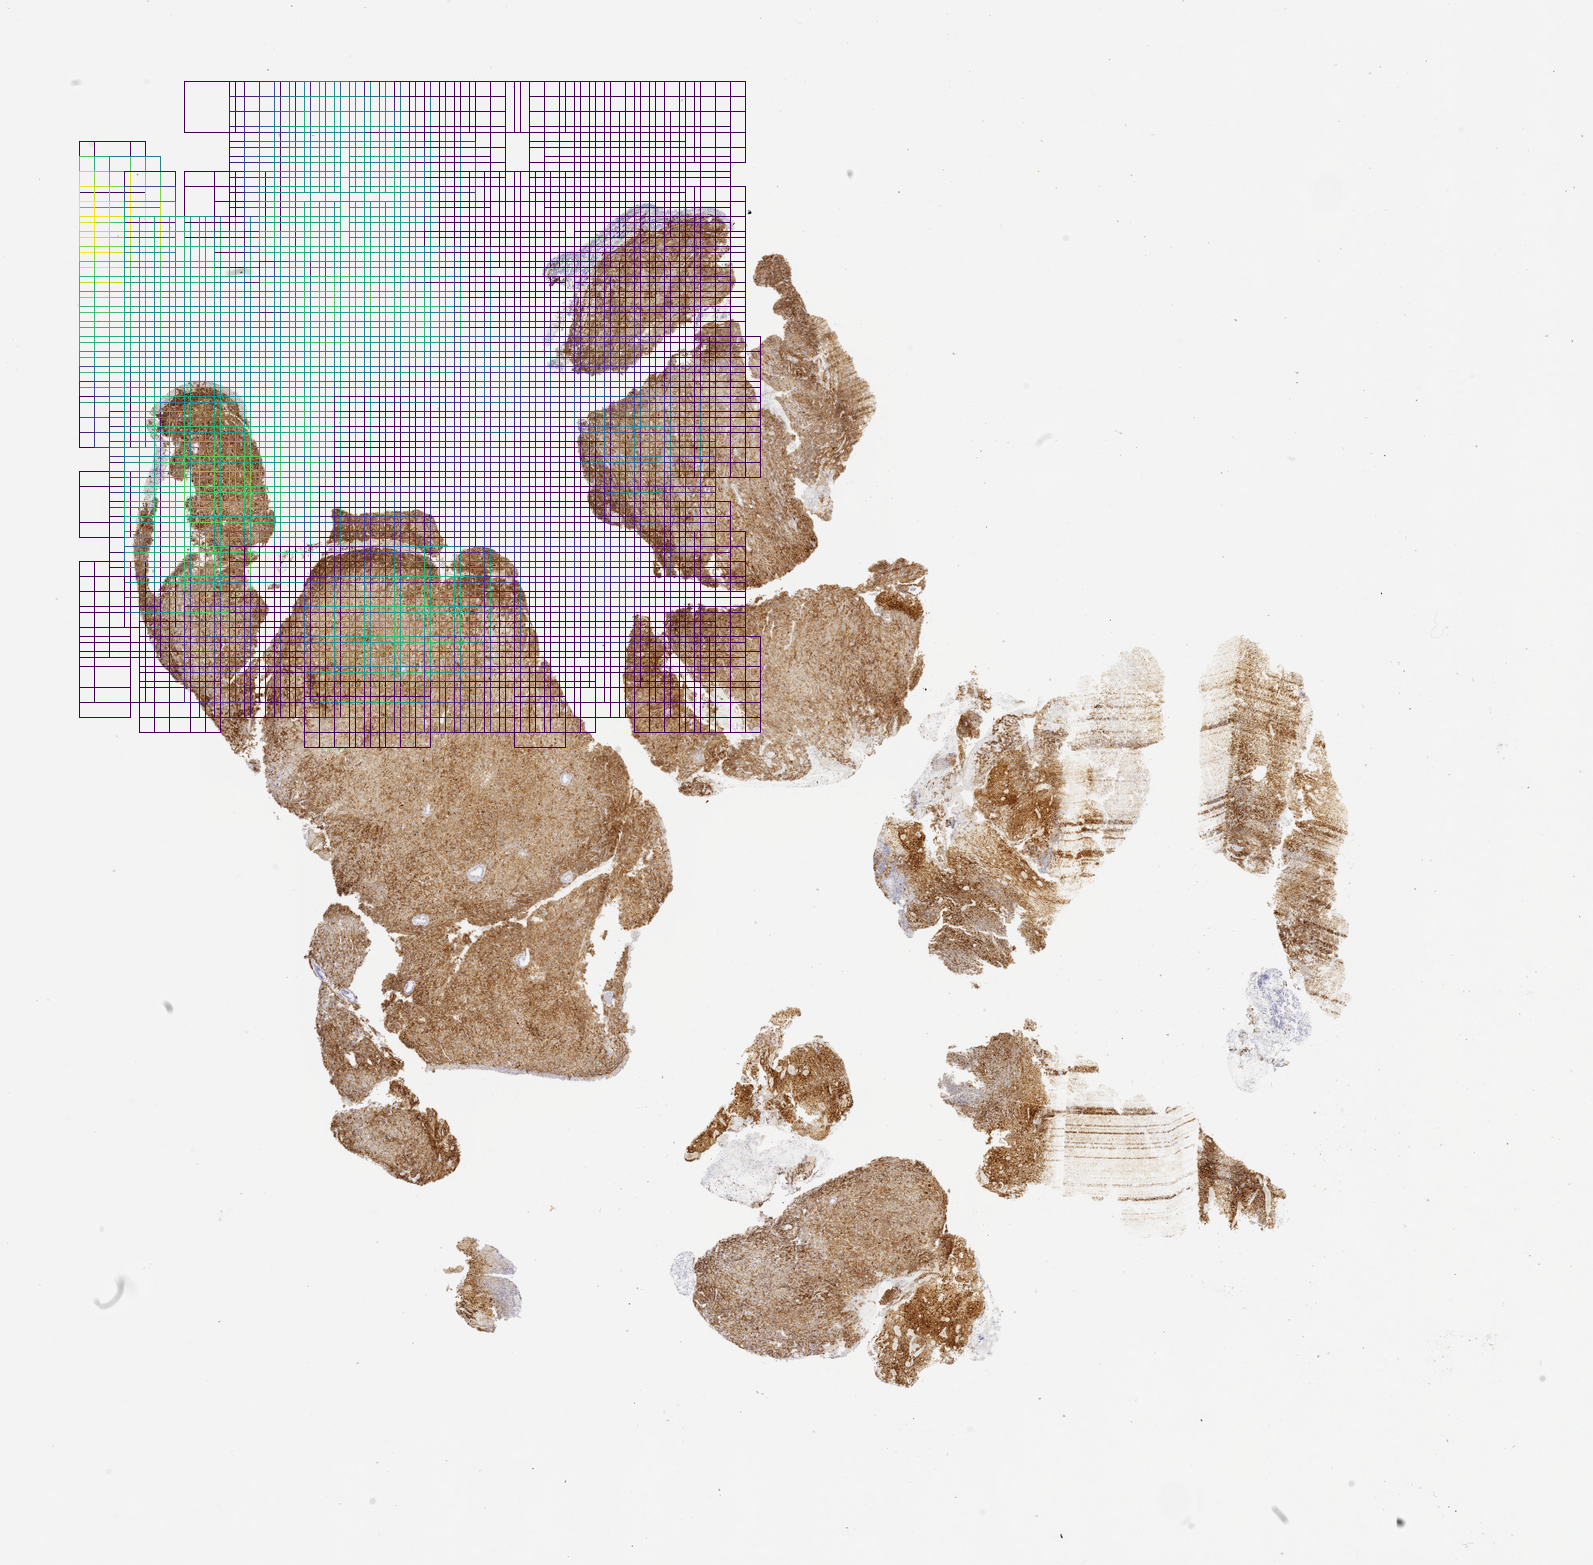

In [17]:
Image(f"{WORKDIR}/kfunct_viz_v3/tile_scores_and_labels_visualization_ikfunction_r160_stainDAB_Cytoplasm_Mean_norm.png")

## Now do some UMAPING
* We consider all the cell features except those relating to the DAB (PD-L1) staining

In [18]:
!ls -l {WORKDIR}/stardist_v3

total 2578849
-rw-r--r-- 1 pollardw pollardw   48651725 Aug  3 15:59 3756135_cell_objects.parquet
-rw-r--r-- 1 pollardw pollardw 2413387118 Aug  3 15:59 cell_detections.geojson
-rw-r--r-- 1 pollardw pollardw  178671770 Aug  3 15:58 cell_detections.tsv
-rw-r--r-- 1 pollardw pollardw        607 Aug  3 15:59 metadata.yml


In [19]:
pd.read_parquet(f"{WORKDIR}/stardist_v3/3756135_cell_objects.parquet")

Image  \
cell_id                                                          
cell-0       93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-1       93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-2       93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-3       93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-4       93ae51da2658d79511e400a129634c33fcffda47002c51...   
...                                                        ...   
cell-354705  93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-354706  93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-354707  93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-354708  93ae51da2658d79511e400a129634c33fcffda47002c51...   
cell-354709  93ae51da2658d79511e400a129634c33fcffda47002c51...   

                       Name  Class                Parent      ROI  x_coord  \
cell_id                                                                      
cell-0       PathCellObject    NaN  PathAnnotationObject  Polygon   6349.3   
cell-1       PathCellObject    NaN  PathAnnotationObject  Polygon   6420.0   
cell-2       PathCellObject    NaN  PathAnnotationObject  Polygon   6404.1   
cell-3       PathCellObject    NaN  PathAnnotationObject  Polygon   6391.7   
cell-4       PathCellObject    NaN  PathAnnotationObject  Polygon   6399.6   
...                     ...    ...                   ...      ...      ...   
cell-354705  PathCellObject    NaN  PathAnnotationObject  Polygon   9067.3   
cell-354706  PathCellObject    NaN  PathAnnotationObject  Polygon   9078.8   
cell-354707  PathCellObject    NaN  PathAnnotationObject  Polygon   9053.8   
cell-354708  PathCellObject    NaN  PathAnnotationObject  Polygon   9068.3   
cell-354709  PathCellObject    NaN  PathAnnotationObject  Polygon   9097.2   

             y_coord  Detection probability  Nucleus: Area µm^2  \
cell_id                                                           
cell-0        2024.7                 0.4655             12.8010   
cell-1        2058.3                 0.3672             11.6556   
cell-2        2060.0                 0.8402             56.9555   
cell-3        2058.0                 0.8270             41.8517   
cell-4        2067.5                 0.7311             34.4110   
...              ...                    ...                 ...   
cell-354705  13912.9                 0.8004             12.5252   
cell-354706  13915.9                 0.7662             15.9203   
cell-354707  13919.8                 0.6786             17.4626   
cell-354708  13928.6                 0.7792             13.3197   
cell-354709  14145.4                 0.5701             14.4228   

             Nucleus: Length µm  ...  DAB: Membrane: Mean  \
cell_id                          ...                        
cell-0                  13.3915  ...               0.0174   
cell-1                  13.2016  ...               0.0623   
cell-2                  27.8769  ...               0.0715   
cell-3                  24.2926  ...               0.0529   
cell-4                  23.4084  ...               0.1031   
...                         ...  ...                  ...   
cell-354705             13.1894  ...               0.4748   
cell-354706             15.1202  ...               0.2720   
cell-354707             15.6631  ...               0.1849   
cell-354708             13.5736  ...               0.1416   
cell-354709             14.1590  ...               0.0158   

             DAB: Membrane: Median  DAB: Membrane: Min  DAB: Membrane: Max  \
cell_id                                                                      
cell-0                      0.0175              0.0094              0.0242   
cell-1                      0.0568              0.0126              0.1559   
cell-2                      0.0707             -0.0064              0.1890   
cell-3                      0.0209             -0.0053              0.1726   
cell-4                      0.1039              0

In [20]:
df = pd.read_parquet(f"{WORKDIR}/stardist_v3/3756135_cell_objects.parquet")

In [21]:
scaler = StandardScaler()
reducer = umap.UMAP()

In [22]:
X_sample = df.select_dtypes(include=np.number).drop(columns=['Class']).dropna().sample(10000)
X_feat = X_sample.drop(columns=['x_coord', 'y_coord'])
X_spat = X_sample[['x_coord', 'y_coord']]

reducer.fit(scaler.fit_transform(X_feat.iloc[:, ~X_feat.columns.str.contains('DAB')]))
embedding = reducer.transform(scaler.fit_transform(X_feat.iloc[:, ~X_feat.columns.str.contains('DAB')]))

Estimated number of clusters: 9
Estimated number of noise points: 267
Silhouette Coefficient: -0.477


<AxesSubplot: xlabel='x_coord', ylabel='y_coord'>

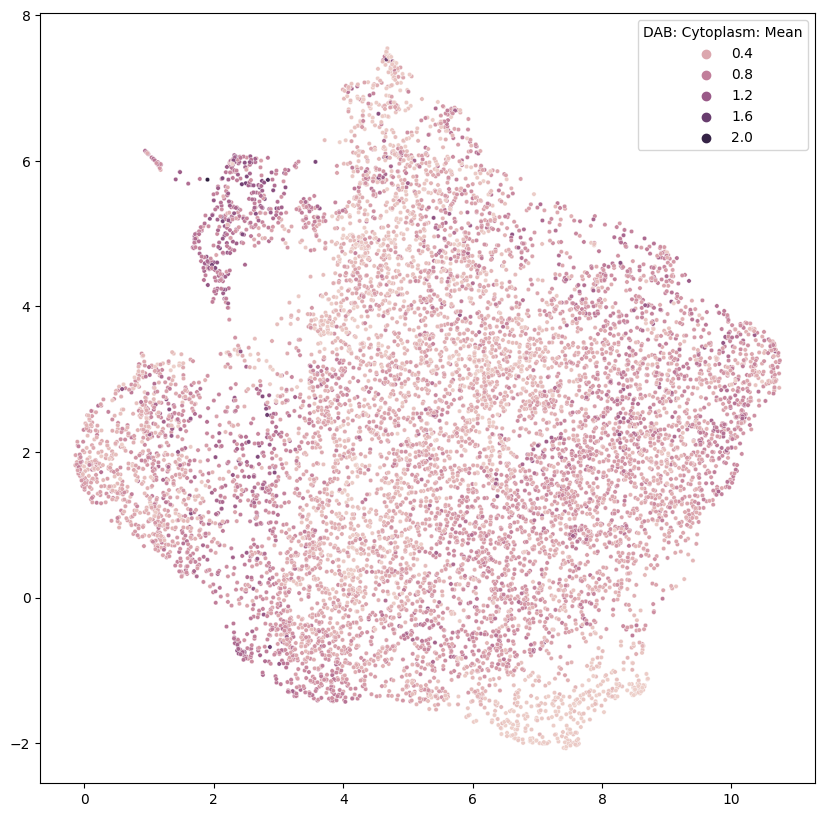

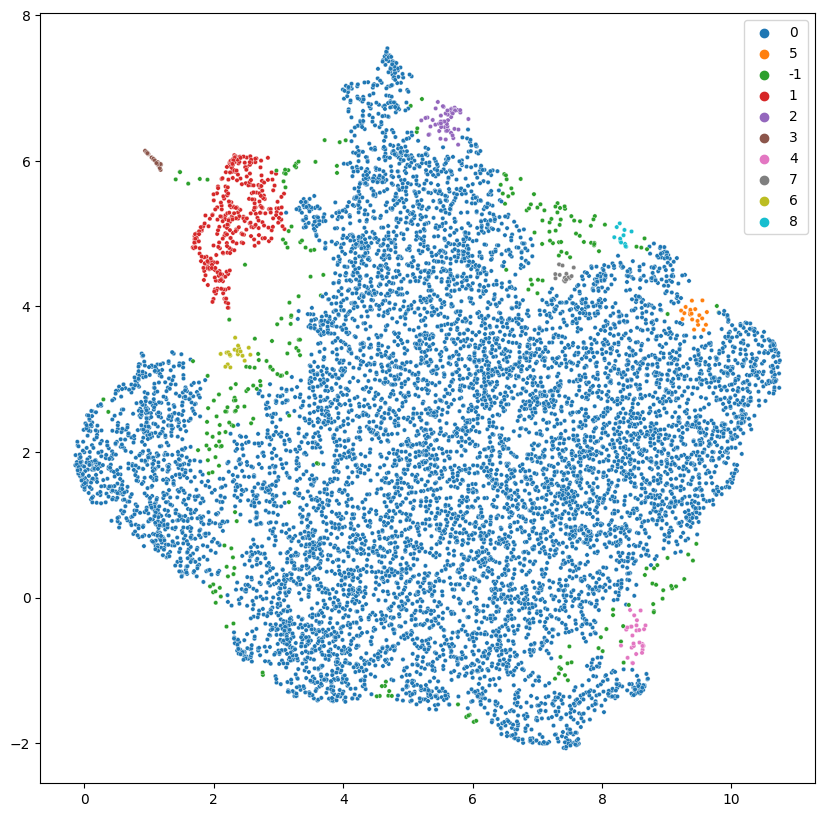

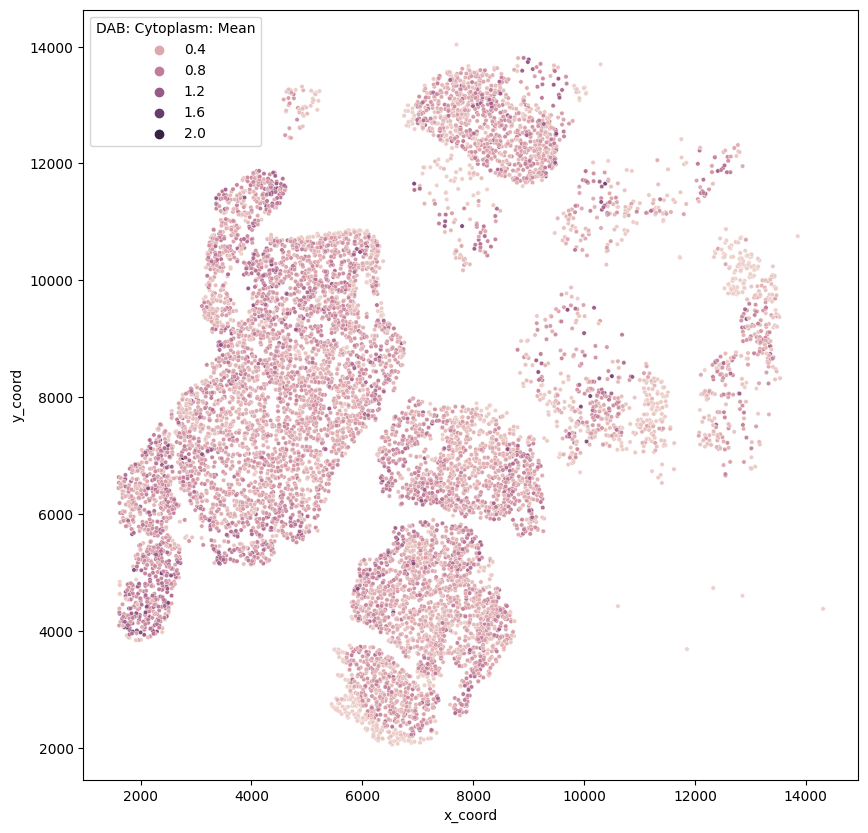

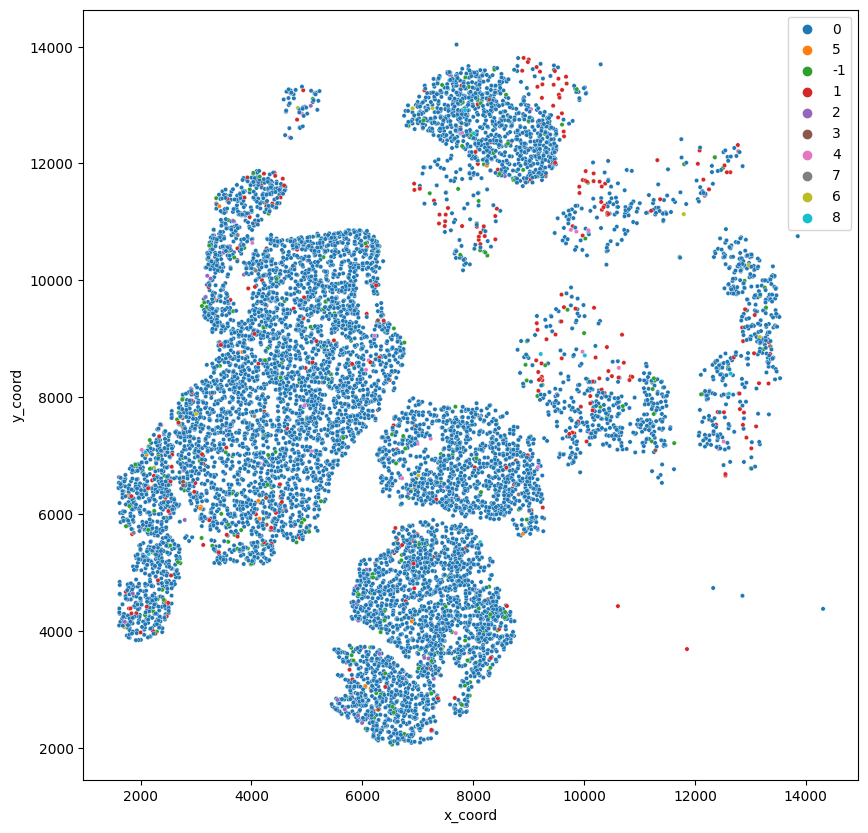

In [23]:
# Compute DBSCAN
db = DBSCAN(eps=0.18, min_samples=12).fit(embedding)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X_feat, labels))

plt.figure(figsize=(10,10))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],  hue=X_feat['DAB: Cytoplasm: Mean'], s=10)

plt.figure(figsize=(10,10))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1],  hue=labels.astype(str), s=10)


plt.figure(figsize=(10,10))
sns.scatterplot(x=X_spat['x_coord'], y=X_spat['y_coord'],  hue=X_feat['DAB: Cytoplasm: Mean'], s=10)

plt.figure(figsize=(10,10))
sns.scatterplot(x=X_spat['x_coord'], y=X_spat['y_coord'], hue=labels.astype(str), s=10)